In [ ]:
import numpy as np
from collections import deque
import random
import pickle

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import layers
from tensorflow import keras

In [ ]:
path = 'drive/MyDrive/Colab Notebooks/Диплом/'

In [ ]:
Q_= 5     # Общее количество портов коммутатора
N = 20    # Общее количество всевозможных потоков

In [ ]:
# Формирование множеств портов для каждого потока n = 1..N
Q = [[]] * N
for n in range(N):
    ports = np.random.choice(np.arange(Q_), size=np.random.randint(1, Q_), replace=False)
    ports.sort()
    Q[n] = ports
Q

[array([1]),
 array([2, 3]),
 array([1]),
 array([1, 4]),
 array([0, 1, 2, 4]),
 array([2, 3]),
 array([0, 1, 2, 4]),
 array([0, 4]),
 array([0]),
 array([0]),
 array([4]),
 array([3]),
 array([2, 4]),
 array([1, 3]),
 array([2, 3, 4]),
 array([4]),
 array([2]),
 array([1, 2, 4]),
 array([4]),
 array([0, 1, 2, 3])]

In [ ]:
T = 2001    # t = 0..T, T - общее количество временных шагов
Times = np.zeros((T, 3))
Times[:, 0] = np.random.randint(0, N, size=T)
Times[:, 1:] = np.random.rand(T, 2)
Times[:, 1] /= 4

def partial_sums(a):
    z = a.copy()
    for i in range(1, z.shape[0]):
        z[i, 0] = z[i - 1, 0] + z[i, 0]
    z[:, 1] += z[:, 0]
    return z

Times[:, 1:] = partial_sums(Times[:, 1:].round(4))
Times

array([[2.000000e+00, 1.922000e-01, 1.115300e+00],
       [2.000000e+00, 3.959000e-01, 1.021700e+00],
       [0.000000e+00, 4.209000e-01, 5.262000e-01],
       ...,
       [7.000000e+00, 2.544239e+02, 2.549684e+02],
       [1.400000e+01, 2.546323e+02, 2.553131e+02],
       [5.000000e+00, 2.547317e+02, 2.548398e+02]])

In [ ]:
# В противном случае перезагрузить (иначе возникнут nan при обучении)
assert(np.unique(Times[:, 1]).shape[0] == T)

In [ ]:
μ = 1          # Параметр интенсивности обслуживания каждого выходного порта коммутатора
S = 5          # Макс. размер очереди

λ = np.random.rand(N).round(2) / 5  # Параметры интенсивности каждого потока
λ              # Необходимо следить за λ

array([0.2  , 0.104, 0.102, 0.102, 0.15 , 0.   , 0.124, 0.15 , 0.044,
       0.156, 0.14 , 0.18 , 0.03 , 0.096, 0.084, 0.134, 0.192, 0.044,
       0.19 , 0.002])

In [ ]:
# Рассчитывает среднюю длину очереди каждого выходного порта
def loading_queue(ρ, s):
    return (ρ ** 2) * (1 - (ρ ** s) * (s + 1 - s * ρ)) / (1 - ρ) / (1 - (ρ ** (s + 2)))

# Рассчитывает суммарную λ для каждого выходного порта
def loading(streams, π, λ):
    ports = π[streams]                      # Выходные порты для текущих потоков
    λ_streams = λ[streams]                  # λ'ы текущих потоков
    load = np.zeros(Q_)
    for i, q in enumerate(ports):
        load[q] += λ_streams[i]
    return load

# Формирование state = <n, V>
# (Times, π, λ, μ, S) -> next_state <n, V>
def next_state_reward(π):
    start = end = Times[0, 1]
    max_time = Times[:, 1:].max()
    V = V_old = V_avg = np.zeros(Q_)

    while end < max_time:
        temp = Times[:, 1:]

        i, j = np.where(temp == start)
        flag_new_stream = (j == 0).any()  # Флаг начала поступления нового потока
        if flag_new_stream:
            t = i.max()
            n = int(Times[t][0])          # Поступающий поток

            V_avg /= (Times[t, 1] - Times[t - 1, 1])
            reward = V_old.max() - V_avg.max()
            π = yield np.concatenate([[n / N], V]), reward
            V_avg = np.zeros(Q_)
            V_old = V.copy()

        end = np.where(temp > start, temp, np.inf).min()
        indxs = np.where(np.logical_and(Times[:, 1] <= start, Times[:, 2] >= end))[0]
        streams = Times[indxs, 0].astype(int)   # Текущие потоки (Например, [1, 2, 5, 7])
        ρ = loading(streams, π, λ) / μ          # ρ для каждого выходного порта
        V = loading_queue(ρ, S) / S             # Загруженность каждой очереди (Средняя длина каждой очереди / макс. размер очереди) - новое состояние
        V_avg += V * (end - start)
        start = end

In [ ]:
def create_network():
    inputs = keras.Input(shape=Q_ + 1)  #Q_ + N
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(Q_, activation='linear')(x)
    return keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
π = np.random.randint(0, Q_, size=N)   #  (Для каждого потока n - номер выходного порта q)
replay_buffer=deque(maxlen=10000)

gamma = 0 #0.9

epsilon = 1.0
epsilon_decay = 0.9
epsilon_min = 0.01

learing_rate = 0.001

episode_num = 3
num_pick_from_buffer = 32
episodes_to_update_weights = 200

loss_function = keras.losses.Huber()
optimizer = keras.optimizers.Adam(learning_rate=0.0025, clipnorm=1.0)

train_network = create_network()
target_network = create_network()
target_network.set_weights(train_network.get_weights())

In [ ]:
def train_from_buffer(replay_buffer):
    if len(replay_buffer) < num_pick_from_buffer:
        return

    samples = random.sample(replay_buffer, num_pick_from_buffer)
    states, actions, rewards, newstates = zip(*samples)
    states, actions, rewards, newstates = np.array(states), np.array(actions), np.array(rewards), np.array(newstates)

    future_rewards = target_network(newstates)
    updated_q_values = rewards + gamma * tf.reduce_max(future_rewards, axis=1)
    masks = tf.one_hot(actions, Q_)

    with tf.GradientTape() as tape:
        q_values = train_network(states)                                        # Train the model on the states and updated Q-values
        q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)          # Apply the masks to the Q-values to get the Q-value for action taken
        loss = loss_function(updated_q_values, q_action)                        # Calculate loss between new Q-value and old Q-value

    # Backpropagation
    grads = tape.gradient(loss, train_network.trainable_variables)
    optimizer.apply_gradients(zip(grads, train_network.trainable_variables))
    return loss.numpy()

In [ ]:
# Несколько эпизодов или один длинный?
# Модификация награды как среднее (день работы коммутатора)
# N или OHE передавать на вход нейронки
# Переписать, как s', r = env(s, a)
# Награда выдается за новое состояние сразу же или при поступлении нового потока???


print(f"Политика очередизации π (поток - порт): {dict(enumerate(π))}\n")

losses = []
rewards = []

for episode in range(episode_num):
    next_state = next_state_reward(π)
    new_state, _ = next(next_state)

    for time in range(1, T):
        state = new_state.copy()
        n = round(state[0] * N)

        # Выбор действия a (Выбирается порт q для потока n), action = ε-greedy [ Q*(n; V) ]
        epsilon = max(epsilon_min, epsilon)
        if np.random.rand() < epsilon:
            action = np.random.randint(0, Q_)                                           #* mask(Q[n])
        else:
            action = np.argmax(train_network.predict(state.reshape(1, -1), verbose=0))  #* mask(Q[n])
        π[n] = action

        # Получение нового состояния и награды
        new_state, reward = next_state.send(π)
        rewards.append(reward)

        # Работа с replay_buffer
        replay_buffer.append([state, action, reward, new_state])
        loss = train_from_buffer(replay_buffer)
        if loss != None: losses.append(loss)

        #update weights every C steps
        if time % episodes_to_update_weights == 0:
            target_network.set_weights(train_network.get_weights())
            epsilon *= epsilon_decay

        # Отладка
        print(f"t = {time:3}   eps: {round(epsilon, 2):4}  Поток: {n:2}    State: {np.array2string(state.round(4), formatter={'float': lambda x: f'{x:7}'}):48}     action = {π[n]}     NewState: {np.array2string(new_state.round(4), formatter={'float': lambda x: f'{x:7}'}):48}   reward = {reward.round(4):8}   loss = {loss}")

Выходные данные были обрезаны до нескольких последних строк (5000).
t = 1001   eps: 0.24  Поток: 13    State: [   0.65     0.0  0.0157  0.0035   0.002   0.109]     action = 2     NewState: [   0.25     0.0  0.0157  0.0288     0.0  0.0395]   reward =   0.0568   loss = 4.887837349087931e-05
t = 1002   eps: 0.24  Поток:  5    State: [   0.25     0.0  0.0157  0.0288     0.0  0.0395]     action = 0     NewState: [    0.9     0.0  0.0157   0.002     0.0  0.0079]   reward =   0.0101   loss = 0.00016213349590543658
t = 1003   eps: 0.24  Поток: 18    State: [    0.9     0.0  0.0157   0.002     0.0  0.0079]     action = 3     NewState: [   0.85     0.0     0.0   0.002  0.0089  0.0079]   reward =   0.0068   loss = 0.00023624912137165666
t = 1004   eps: 0.24  Поток: 17    State: [   0.85     0.0     0.0   0.002  0.0089  0.0079]     action = 1     NewState: [    0.8     0.0  0.0004   0.002  0.0089     0.0]   reward =      0.0   loss = 0.00020583604054991156
t = 1005   eps: 0.24  Поток: 16    State:

In [ ]:
for episode in range(episode_num):
    next_state = next_state_reward(π)
    new_state, _ = next(next_state)

    for time in range(1, T):
        state = new_state.copy()
        n = round(state[0] * N)

        # Выбор действия a (Выбирается порт q для потока n), action = ε-greedy [ Q*(n; V) ]
        epsilon = max(epsilon_min, epsilon)
        if np.random.rand() < epsilon:
            action = np.random.randint(0, Q_)                                           #* mask(Q[n])
        else:
            action = np.argmax(train_network.predict(state.reshape(1, -1), verbose=0))  #* mask(Q[n])
        π[n] = action

        # Получение нового состояния и награды
        new_state, reward = next_state.send(π)
        rewards.append(reward)

        # Работа с replay_buffer
        replay_buffer.append([state, action, reward, new_state])
        loss = train_from_buffer(replay_buffer)
        if loss != None: losses.append(loss)

        #update weights every C steps
        if time % episodes_to_update_weights == 0:
            target_network.set_weights(train_network.get_weights())
            epsilon *= epsilon_decay

        # Отладка
        print(f"t = {time:3}   eps: {round(epsilon, 2):4}  Поток: {n:2}    State: {np.array2string(state.round(4), formatter={'float': lambda x: f'{x:7}'}):48}     action = {π[n]}     NewState: {np.array2string(new_state.round(4), formatter={'float': lambda x: f'{x:7}'}):48}   reward = {reward.round(4):8}   loss = {loss}")

Выходные данные были обрезаны до нескольких последних строк (5000).
t = 1001   eps: 0.01  Поток: 13    State: [   0.65  0.2348     0.0  0.0124  0.0004     0.0]     action = 2     NewState: [   0.25  0.1195     0.0  0.0288  0.0004     0.0]   reward =   0.0942   loss = 0.0002007202128879726
t = 1002   eps: 0.01  Поток:  5    State: [   0.25  0.1195     0.0  0.0288  0.0004     0.0]     action = 3     NewState: [    0.9  0.0451     0.0   0.002  0.0004     0.0]   reward =   0.0238   loss = 0.00014015739725437015
t = 1003   eps: 0.01  Поток: 18    State: [    0.9  0.0451     0.0   0.002  0.0004     0.0]     action = 4     NewState: [   0.85  0.0079     0.0   0.002     0.0  0.0089]   reward =   0.0335   loss = 3.577626921469346e-05
t = 1004   eps: 0.01  Поток: 17    State: [   0.85  0.0079     0.0   0.002     0.0  0.0089]     action = 1     NewState: [    0.8     0.0  0.0004   0.002     0.0  0.0089]   reward =      0.0   loss = 0.00011968251055805013
t = 1005   eps: 0.01  Поток: 16    State: 

In [ ]:
# Тест обученной модели. Действия выбираются только с помощью модели

next_state = next_state_reward(π)
new_state, _ = next(next_state)

for t in range(1, 101):
    state = new_state.copy()
    n = round(state[0] * N)

    # Выбор действия a
    action = np.argmax(train_network.predict(state.reshape(1, -1), verbose=0))  #* mask(Q[n])
    π[n] = action

    # Получение нового состояния и награды
    new_state, reward = next_state.send(π)

    # Расчет награды
    reward = state[1:].max() - new_state[1:].max()
    loss = None

    # Отладка
    print(f"t = {t:3}   eps: {round(epsilon, 2):4}  Поток: {n:2}    State: {np.array2string(state.round(4), formatter={'float': lambda x: f'{x:7}'}):48}     action = {π[n]}     NewState: {np.array2string(new_state.round(4), formatter={'float': lambda x: f'{x:7}'}):48}   reward = {reward.round(4):8}   loss = {loss}")

Политика очередизации π (поток - порт): {0: 3, 1: 3, 2: 3, 3: 3, 4: 3, 5: 0, 6: 3, 7: 4, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 3, 14: 3, 15: 3, 16: 0, 17: 4, 18: 0, 19: 3}

t =   1   eps: 0.01  Поток:  2    State: [    0.1    -0.0    -0.0    -0.0    -0.0    -0.0]     action = 3     NewState: [    0.1     0.0     0.0     0.0  0.0023     0.0]   reward =  -0.0023   loss = None
t =   2   eps: 0.01  Поток:  2    State: [    0.1     0.0     0.0     0.0  0.0023     0.0]     action = 3     NewState: [    0.0     0.0     0.0     0.0  0.0104     0.0]   reward =  -0.0081   loss = None
t =   3   eps: 0.01  Поток:  0    State: [    0.0     0.0     0.0     0.0  0.0104     0.0]     action = 4     NewState: [    0.9     0.0     0.0     0.0  0.0104     0.0]   reward =      0.0   loss = None
t =   4   eps: 0.01  Поток: 18    State: [    0.9     0.0     0.0     0.0  0.0104     0.0]     action = 0     NewState: [   0.35  0.0089     0.0     0.0  0.0104     0.0]   reward =      0.0   loss = None
t =   5   ep

In [ ]:
#Соранение
train_network.save(path + 'TrainNN.h5')

with open(path + 'rewards.pkl', 'wb') as file:
    pickle.dump(rewards, file)

with open(path + 'losses.pkl', 'wb') as file:
    pickle.dump(losses, file)

In [ ]:
# Загрузка
"""with open(path + 'rewards.pkl', 'rb') as file:
    rewards = pickle.load(file)

with open(path + 'losses.pkl', 'rb') as file:
    losses = pickle.load(file)"""

In [ ]:
np_rewards = np.array(rewards)
np_losses = np.array(losses)
K = 200  #Параметр усреднения

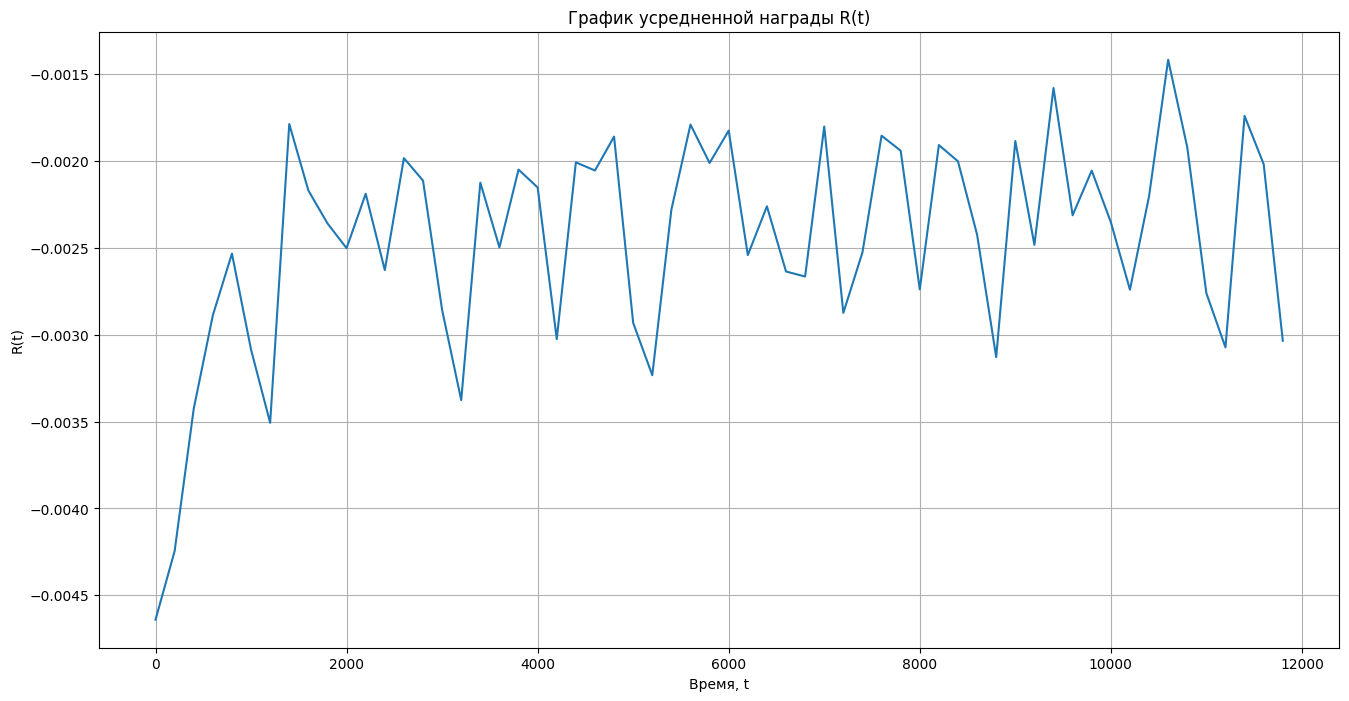

In [ ]:
avg_rewards = np.array(np_rewards).reshape(-1, K).sum(axis=1) / K
x = np.arange(avg_rewards.shape[0]) * K

plt.figure(figsize=(16, 8))
plt.title('График усредненной награды R(t)')
plt.xlabel('Время, t')
plt.ylabel('R(t)')
plt.plot(x, avg_rewards)
plt.grid(True)
plt.show()

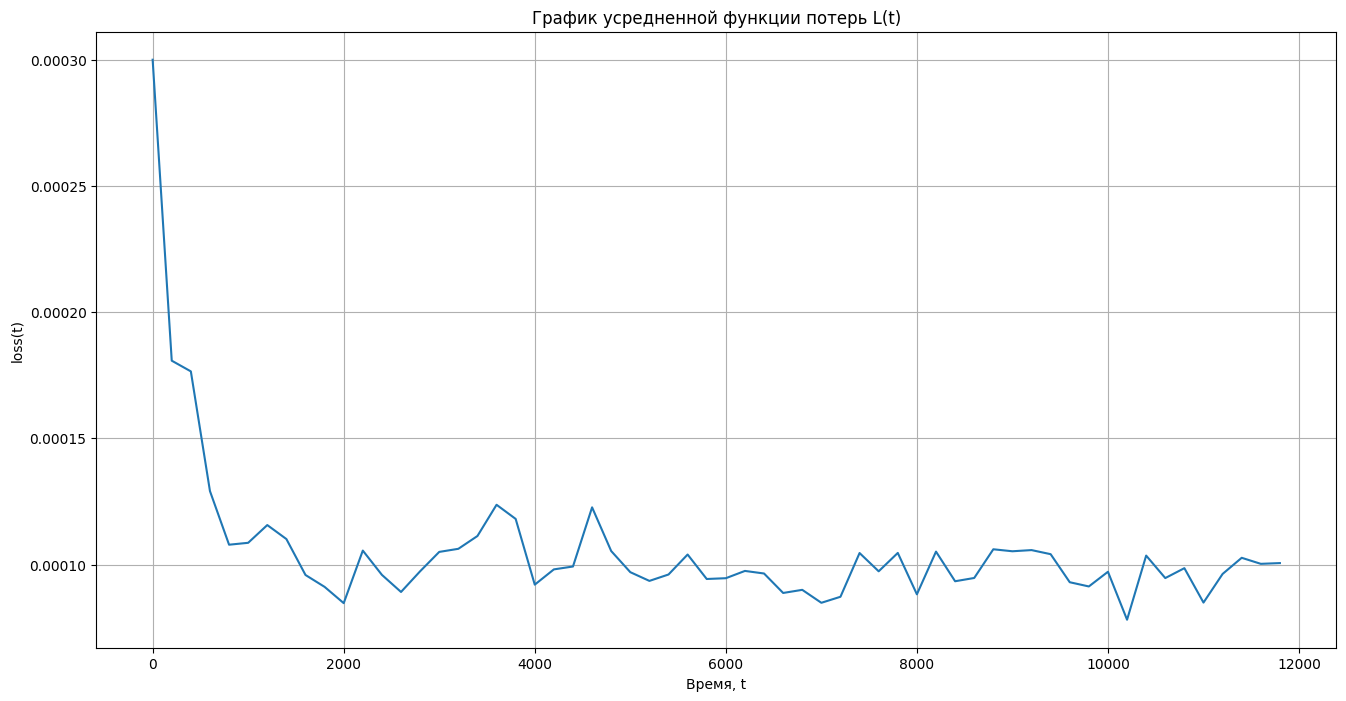

In [ ]:
sum_losses = np.insert(np.array(np_losses), len(np_losses), [0] * (num_pick_from_buffer - 1)).reshape(-1, K).sum(axis=1) / K

plt.figure(figsize=(16, 8))
plt.plot(x, sum_losses)
plt.title('График усредненной функции потерь L(t)')
plt.xlabel('Время, t')
plt.ylabel('loss(t)')
plt.grid(True)
plt.show()